## Classification Attention Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import keras
from keras import backend as K
import tensorflow as tf

import sys
import os
import numpy as np
import pandas as pd
import scipy

import Bio
from Bio import SeqIO
import Bio.motifs

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
import sklearn

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from signal_models import *
from utility_functions import *

sys.path.insert(0, '/home/jtao/code/tba/motif_tools')
from motif_utilities import *

sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
working_directory = '/home/jtao/analysis/genomic_grammar_analysis/'

## Read Data

In [3]:
treatment_positive_fasta_dict = {}
treatment_negative_fasta_dict = {}
treatment_positive_seqArray_dict = {}
treatment_positive_rc_seqArray_dict = {}
treatment_negative_seqArray_dict = {}
treatment_negative_rc_seqArray_dict = {}

for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]
    
    positive_fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]
    negative_fasta_seq = [str(x.seq[:200]) for x in negative_seqRecords]
    
    positive_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords]
    negative_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]
    
    positive_sequence_arrays = convert_sequences_to_array(positive_fasta_seq)
    positive_rc_sequence_arrays = convert_sequences_to_array(positive_rc_fasta_seq)
    
    negative_sequence_arrays = convert_sequences_to_array(negative_fasta_seq)
    negative_rc_sequence_arrays = convert_sequences_to_array(negative_rc_fasta_seq)
    
    treatment_positive_fasta_dict[treatment] = positive_fasta_seq
    treatment_negative_fasta_dict[treatment] = negative_fasta_seq
    treatment_positive_seqArray_dict[treatment] = positive_sequence_arrays
    treatment_positive_rc_seqArray_dict[treatment] = positive_rc_sequence_arrays
    treatment_negative_seqArray_dict[treatment] = negative_sequence_arrays
    treatment_negative_rc_seqArray_dict[treatment] = negative_rc_sequence_arrays

*** kla-1h ***
*** veh ***
*** il4-24h ***


## Set Model Settings

In [147]:
### settings for attention model ###
attention_num_motifs=150
attention_motif_size=16
adjacent_bp_pool_size=1
attention_num_dense_neurons = 1
attention_dropout_rate=0.1

## Read in Models

In [148]:
condition_model_dict = {}
for f in os.listdir(working_directory + '/models_classification/'):
    treatment_modelType = f.replace('_weights.h5','')
    modelType = treatment_modelType.split('_')[0]
    if modelType == 'DotAttention':
        current_model = get_dotProductAttention_model(200,
            mode='classification',
            num_motifs=attention_num_motifs, 
            motif_size=attention_motif_size,
            adjacent_bp_pool_size=adjacent_bp_pool_size,
            num_dense_neurons = attention_num_dense_neurons,
            dropout_rate=attention_dropout_rate,
            num_classes=2)
        current_model.load_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5')
        condition_model_dict[treatment_modelType] = current_model
        print(f, current_model.count_params())

DotAttention_kla-1h_weights.h5 10753
DotAttention_veh_weights.h5 10753
DotAttention_il4-24h_weights.h5 10753


## Get correctly classified sequences

In [149]:
treatment_truePositive_seqArray_dict = {}
for treatment in sorted(treatment_positive_seqArray_dict.keys()):
    positive_sequence_arrays = treatment_positive_seqArray_dict[treatment] 
    
    current_model = condition_model_dict['DotAttention_' + treatment]
    
    probs = current_model.predict([positive_sequence_arrays])
    predictions = np.array([0 if x[0] > x[1] else 1 for x in probs])
    truePositve_sequence_arrays = positive_sequence_arrays[predictions == 1]
    treatment_truePositive_seqArray_dict[treatment] = truePositve_sequence_arrays

    print(treatment, len(truePositve_sequence_arrays)/len(positive_sequence_arrays))

il4-24h 0.9252640372337252
kla-1h 0.9226212343864806
veh 0.8527099841521395


## Weight Extraction

In [155]:
def get_sequence_attention(model, sequence_arrays, sequence_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_softmax_layer').output])
    trimmed_sequences = [x[:sequence_size] for x in sequence_arrays]
    
    attention = get_attention((trimmed_sequences, 0))[0]

    return attention

In [151]:
treatment_attention_dict = {}
for treatment in sorted(treatment_truePositive_seqArray_dict.keys()):
    print('***',treatment, '***')

    sequence_arrays = treatment_truePositive_seqArray_dict[treatment]
    if 'DotAttention_'+treatment in condition_model_dict:
        current_model = condition_model_dict['DotAttention_'+treatment]

        attention = get_sequence_attention(current_model,
            sequence_arrays,
            200)

        treatment_attention_dict[treatment] = attention


*** il4-24h ***
*** kla-1h ***
*** veh ***


## Visualize Attention

In [165]:
attention = treatment_attention_dict['kla-1h']

### Overall Matrix

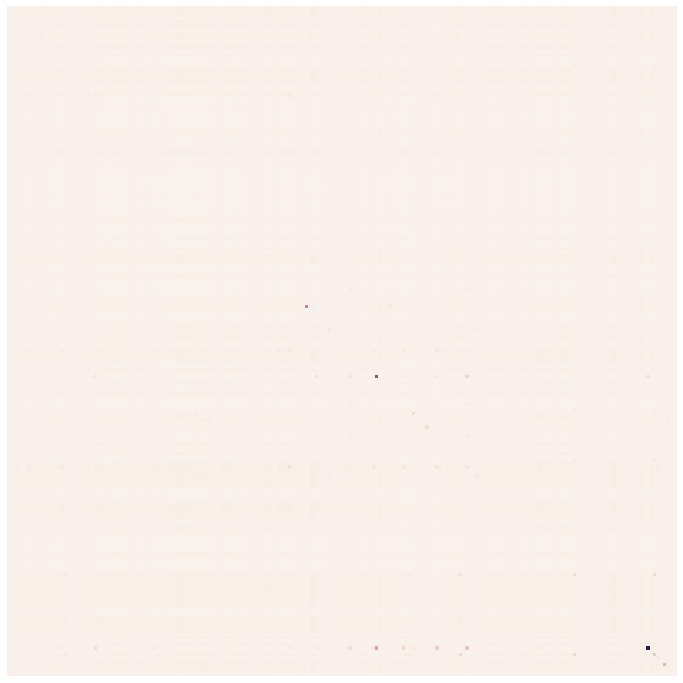

In [170]:
index = 1811
plt.figure(figsize=(15,15))
hm = sns.heatmap(attention[index], 
            yticklabels = False, 
            xticklabels = False, 
            square = True,
           vmin=0,
#            vmax=0.4
           )
cb = hm.collections[0].colorbar
cb.ax.set_visible(False)

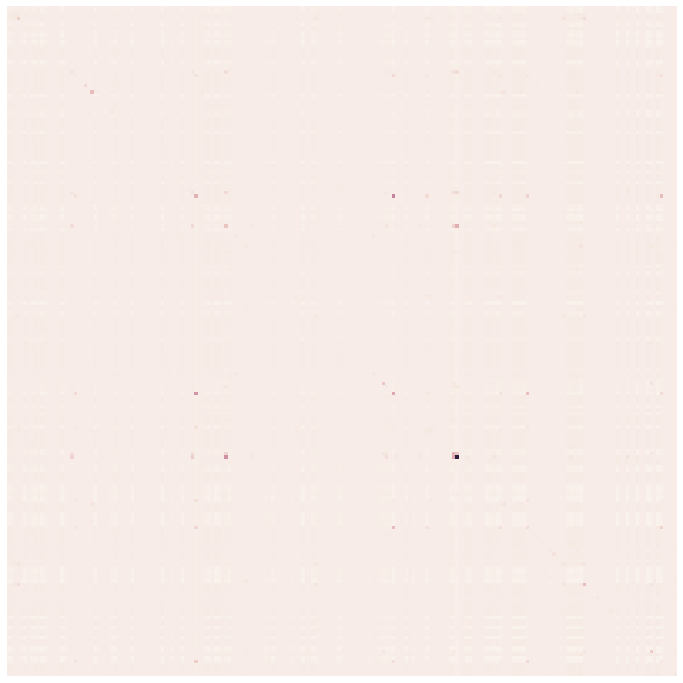

In [169]:
index = 19999
# index = 19996
plt.figure(figsize=(15,15))
hm = sns.heatmap(attention[index], 
            yticklabels = False, 
            xticklabels = False, 
            square = True,
#            vmin=0,
#            vmax=0.1
           )
cb = hm.collections[0].colorbar
cb.ax.set_visible(False)

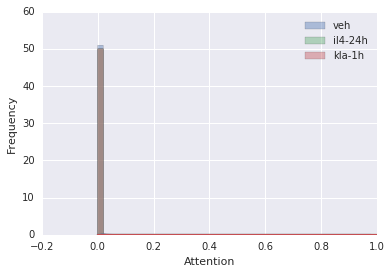

In [139]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    sns.distplot(treatment_attention[:100].flatten(), label = treatment)
plt.xlabel('Attention')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [157]:
num_positions = 200
matrix_size = num_positions**2
count_list = []
treatment_list = []
threshold_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    print(treatment)
    
    for threshold in [np.round(x,2) for x in np.arange(0.1,1,0.1)]:
        counter = 0
        print(threshold)
        for am in treatment_attention:
            count = np.sum(am.flatten() > threshold)
            count_list.append(count)
#             normalized_count_list.append(count/matrix_size)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
#             counter+=1
#             if counter % 10000 == 0:
#                 print(counter)

veh
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
il4-24h
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
kla-1h
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [158]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list})

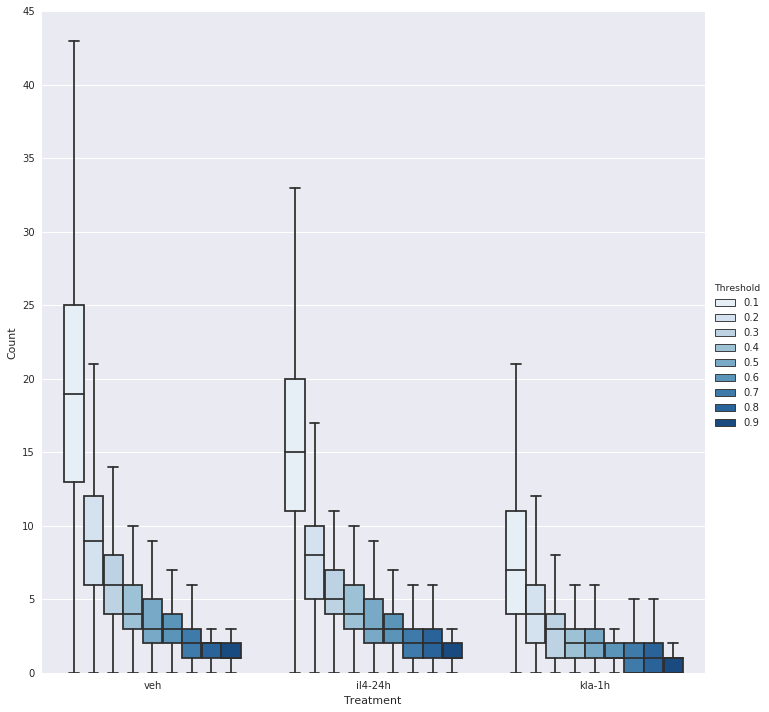

In [159]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Blues',
    showfliers=False,
    size = 10)

### Max per Position

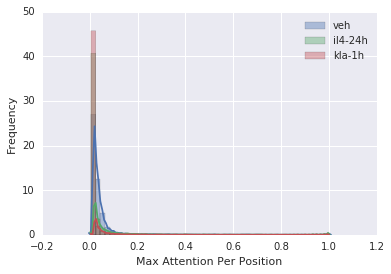

In [160]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=0) for x in treatment_attention[:100]])
    sns.distplot(max_attention.flatten(), label = treatment)
plt.xlabel('Max Attention Per Position')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [161]:
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=0) for x in treatment_attention])
    print(treatment)
    for threshold in [np.round(x,2) for x in np.arange(0.1,1,0.1)]:
        for fam in max_attention:
            count = np.sum(fam.flatten() >= threshold)
            count_list.append(count)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
        


veh
il4-24h
kla-1h


In [162]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list})

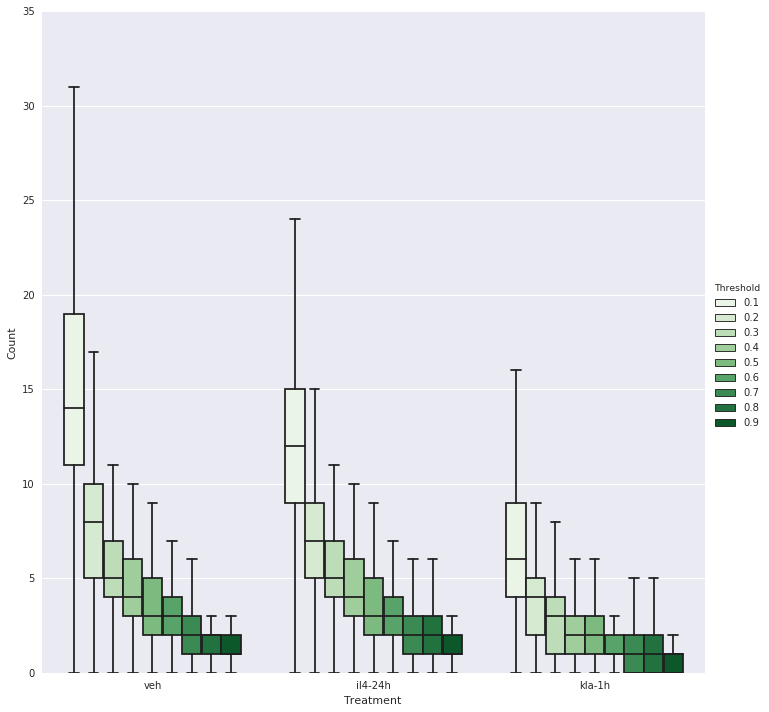

In [163]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Greens',
    showfliers=False,
    size = 10)


## Motif Extraction

In [195]:
def get_sequence_motif_scores(model, sequence_arrays, sequence_size):
    get_convolution_kernels = K.function([model.get_layer('input_fwd').input, 
                                K.learning_phase()
                               ], 
                               [model.get_layer('convolution_layer').output])
    trimmed_sequences = [x[:sequence_size] for x in sequence_arrays]
    
    motif_scores = np.array(get_convolution_kernels((trimmed_sequences, 0)))

    return np.squeeze(motif_scores)

In [196]:
treatment_motifScores_dict = {}
for treatment in sorted(treatment_truePositive_seqArray_dict.keys()):
    print('***',treatment, '***')

    sequence_arrays = treatment_truePositive_seqArray_dict[treatment]
    if 'DotAttention_'+treatment in condition_model_dict:
        current_model = condition_model_dict['DotAttention_'+treatment]

        scores = get_sequence_motif_scores(current_model,
            sequence_arrays,
            200)

        treatment_motifScores_dict[treatment] = scores


*** il4-24h ***
*** kla-1h ***
*** veh ***


### Compare Convolution kernels to known motifs

In [435]:
def normalize_motif(motif):
    normed_motif = np.zeros(motif.shape)
    mins = motif.min(axis=1)
    for i in range(4):
        normed_motif[:,i] = motif[:,i] - mins
    sums = normed_motif.sum(axis = 1)
    for i in range(4):
        normed_motif[:,i] = normed_motif[:,i]/sums
    return normed_motif

In [356]:
motifs = current_model.get_layer('convolution_layer').get_weights()[0]

In [436]:
motifs.shape

(16, 4, 150)

In [299]:
index_seq_dict = dict(zip(range(4), ['A','C', 'G', 'T']))

CGAAACTGCAACTCGT


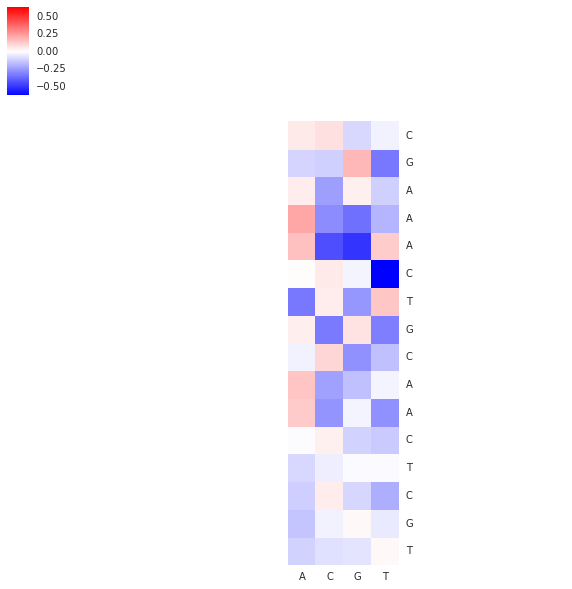

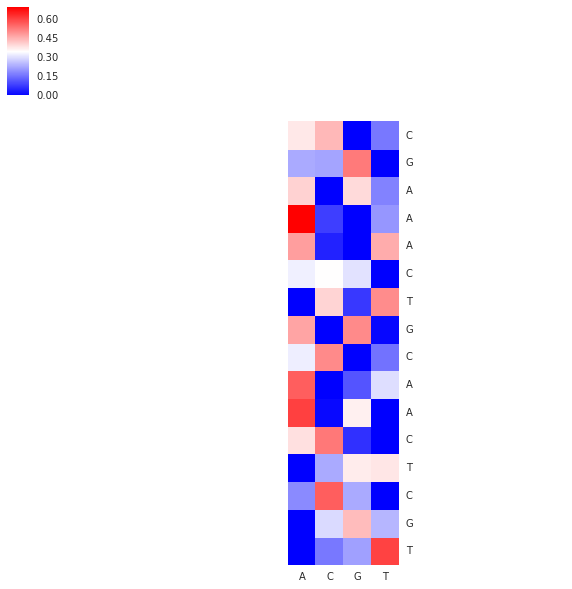

AGTGACGTTAGAGACT


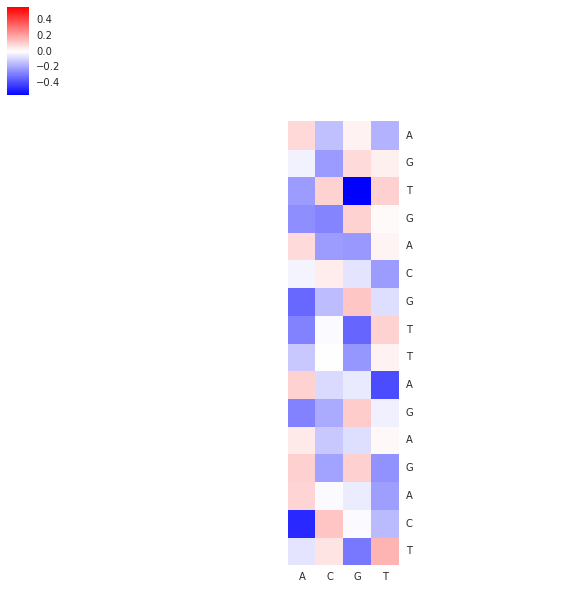

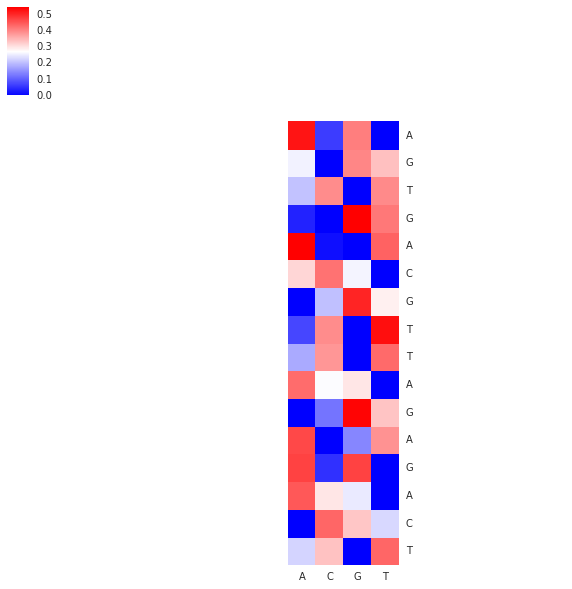

In [363]:
seq_list = []
for i in range(motifs.shape[-1]):
    motif = motifs[:,:,i]
    normed_motif = normalize_motif(motif)
    
    sequence = ''.join([index_seq_dict[np.argmax(x)] for x in motif])
    seq_list.append(sequence)
    motif_to_plot = pd.DataFrame(motif, index = list(sequence), columns=['A','C','G','T'])
    normed_motif_to_plot = pd.DataFrame(normed_motif, index = list(sequence), columns=['A','C','G','T'])
    print(sequence)
    cg = sns.clustermap(motif_to_plot,
              row_cluster = False,
              col_cluster=False,
              cmap='bwr',
              square = True
              )
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()
    
    cg = sns.clustermap(normed_motif_to_plot,
                  row_cluster = False,
                  col_cluster=False,
                  cmap='bwr',
                  square = True
                  )
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()
    if i == 1:
        break


#### Score motifs against library

In [370]:
def readMotifFile(motifPath):
    with open(motifPath) as f:
        m = Bio.motifs.read(f, 'jaspar')
    name = m.name
    matrix = [m.pwm['A'], m.pwm['C'], m.pwm['G'], m.pwm['T']]
    matrix = np.array(matrix).T
    
    return (name,np.array(matrix), m.matrix_id)

In [454]:
def find_best_matching_motif(motif, motif_library):
    cleaned_motif_1 = (motif[0], cleanMatrix(motif[1]))
    similarity_scores = []
    counter = 0
    for other_motif in motif_library:
        cleaned_motif_2 = (other_motif[0], cleanMatrix(other_motif[1]))
        alignment_fwd, alignScore_fwd = local_align_motifs(cleaned_motif_1, cleaned_motif_2)
        r_fwd = calcCorrelation(alignment_fwd[0], alignment_fwd[1])
        alignment_rev, alignScore_rev = local_align_motifs(cleaned_motif_1, revCompMotif(cleaned_motif_2))
        r_rev = calcCorrelation(alignment_rev[0], alignment_rev[1])
        r = np.max([r_fwd, r_rev])
        similarity_scores.append(r)
    best_index = np.argmax(similarity_scores)
    best_score = similarity_scores[best_index]
    best_motif = motif_library[best_index]
    
    return best_score, best_motif, similarity_scores

In [462]:
def minmax_normalize_motif(motif):
    normed_motif = np.zeros(motif.shape)
    mins = motif.min(axis=1)
    for i in range(4):
        normed_motif[:,i] = motif[:,i] - mins
    distances = motif.max(axis = 1) - motif.min(axis=1)
    for i in range(4):
        normed_motif[:,i] = normed_motif[:,i]/distances
    return normed_motif

In [383]:
# read in motif library
motif_dir = '/home/jtao/code/tba/default_motifs/'
motif_library = []
for f in os.listdir(motif_dir):
    motif = readMotifFile(motif_dir + f)
    motif_library.append(motif)

In [ ]:
treatment_conv_motif_dict = {}
for condition in sorted(condition_model_dict.keys()):
    treatment = condition.split('_')[1]
    print('***', treatment, '***')
    conv_motif_dict = {}
    current_model = condition_model_dict[condition]
    motifs = current_model.get_layer('convolution_layer').get_weights()[0]
    all_scores = []
    for i in range(motifs.shape[-1]):
        motif = motifs[:,:,i]

        kernel_name = treatment +  '_' + str(i)
        normed_motif = (kernel_name, normalize_motif(motif))
#         best_score, best_motif, similarity_scores = find_best_matching_motif(normed_motif, motif_library)
        best_score, best_motif, similarity_scores = find_best_matching_motif((kernel_name, 
                                                                              minmax_normalize_motif(motif)), motif_library)
        all_scores.append(best_score)
        print(i, best_motif[0], best_score)
        conv_motif_dict[kernel_name] = best_motif[0]
    sns.distplot(all_scores)
    plt.title(treatment)
    plt.xlabel('Pearson Corrlation of Best Matching Motif')
    treatment_conv_motif_dict[treatment] = conv_motif_dict

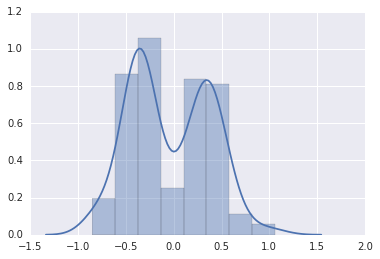

In [478]:
sns.distplot(current_model.get_layer('dense_layer').get_weights()[0])

In [466]:
import pickle

In [467]:
if len(treatment_conv_motif_dict) > 0:
    with open(working_directory + '/treatment_conv_motif_dict.pickle', 'wb') as handle:
        pickle.dump(treatment_conv_motif_dict, handle)

In [487]:
with open(working_directory + '/treatment_conv_motif_dict.pickle', 'rb') as handle:
    treatment_conv_motif_dict = pickle.load(handle)

In [402]:
motifs = current_model.get_layer('convolution_layer').get_weights()[0]


In [423]:
best_score, best_motif, similarity_scores = find_best_matching_motif(('motif_0', normalized_motifs[0]), motif_library)
print(best_motif[0], best_score)

/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


STAT1::STAT2 0.5372788893663792


### Visualize Motif Scores

#### Summarize mean and variance

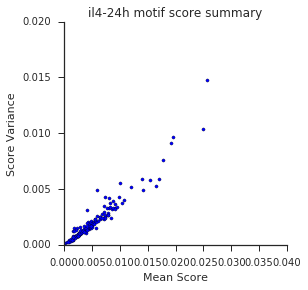

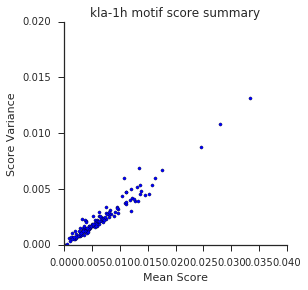

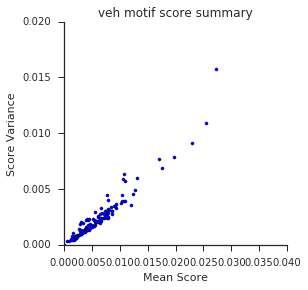

In [223]:
for treatment in sorted(treatment_motifScores_dict.keys()):
    variances = []
    means = []
    for i in range(scores.shape[-1]):
        scores = treatment_motifScores_dict[treatment]
        flattened_scores = scores[:,:,i].flatten()
        score_mean = np.mean(flattened_scores)
        score_var = np.var(flattened_scores)
        means.append(score_mean)
        variances.append(score_var)
    with sns.axes_style('ticks'):
        plt.scatter(means, 
                    variances,
                    edgecolor=None,
                    s=10)
        plt.xlim(0,0.04)
        plt.ylim(0,0.02)
        ax = plt.gca()
        ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])

        plt.title(treatment + ' motif score summary')
        plt.xlabel('Mean Score')
        plt.ylabel('Score Variance')
        sns.despine()
        plt.show()


#### Test for normality

In [249]:
threshold = 0.01
pval_lists = []
for treatment in sorted(treatment_motifScores_dict.keys()):
    print(treatment,'***')
    log_pvals = []
    for i in range(scores.shape[-1]):
        scores = treatment_motifScores_dict[treatment]
        flattened_scores = scores[:,:,i].flatten()
        
        stat, pval = scipy.stats.normaltest(flattened_scores)
        log_pvals.append(pval)
        if pval > threshold:
            print(i, 'mean:', np.mean(flattened_scores), 'var:', np.var(flattened_scores))
    
    print(treatment, np.sum(np.array(log_pvals) > threshold))


il4-24h ***
62 mean: 0.0 var: 0.0
il4-24h 1
kla-1h ***
2 mean: 0.0 var: 0.0
39 mean: 0.0 var: 0.0
42 mean: 0.0 var: 0.0
45 mean: 0.0 var: 0.0
50 mean: 0.0 var: 0.0
70 mean: 0.0 var: 0.0
114 mean: 0.0 var: 0.0
116 mean: 0.0 var: 0.0
kla-1h 8
veh ***
138 mean: 0.0 var: 0.0
139 mean: 0.0 var: 0.0
veh 2


#### Fraction of positions with significant score

il4-24h ***


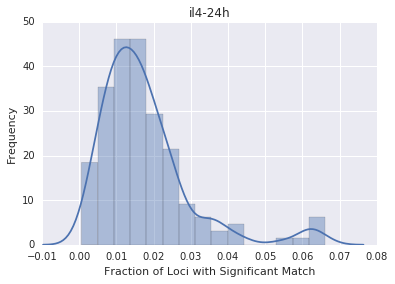

kla-1h ***


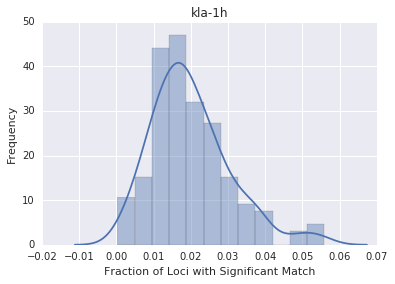

veh ***


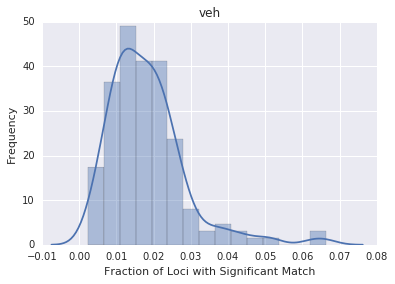

In [282]:
threshold = 2
pval_lists = []
for treatment in sorted(treatment_motifScores_dict.keys()):
    print(treatment,'***')
    fractions = []
    for i in range(scores.shape[-1]):
        scores = treatment_motifScores_dict[treatment]
        flattened_scores = scores[:,:,i].flatten()
        if np.var(flattened_scores) > 0:
            zscores = scipy.stats.zscore(flattened_scores)
            sig_fraction = np.sum(zscores > threshold)

            fractions.append(sig_fraction/len(flattened_scores))
    sns.distplot(fractions)
    plt.title(treatment)
    plt.xlabel('Fraction of Loci with Significant Match')
    plt.ylabel('Frequency')
    plt.show()



#### Fraction of sequences with significant score

il4-24h ***


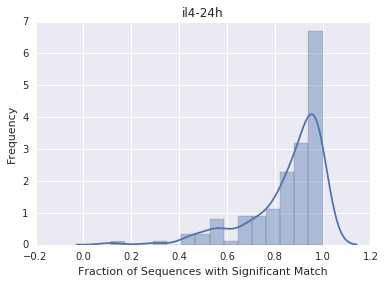

kla-1h ***


/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


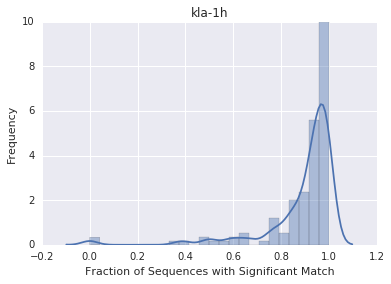

veh ***


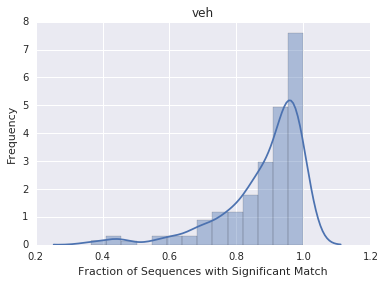

In [281]:
threshold = 2
pval_lists = []
for treatment in sorted(treatment_motifScores_dict.keys()):
    print(treatment,'***')
    fractions = []
    for i in range(scores.shape[-1]):
        scores = treatment_motifScores_dict[treatment]
        current_scores = scores[:,:,i]
        if np.var(current_scores) > 0:
            zscores = scipy.stats.zscore(current_scores)
            sig_fraction = np.sum(zscores.max(axis=1) > threshold)

            fractions.append(sig_fraction/len(scores))
    sns.distplot(fractions)
    plt.title(treatment)
    plt.xlabel('Fraction of Sequences with Significant Match')
    plt.ylabel('Frequency')
    plt.show()




#### Convert Motif Scores to p-values

In [254]:
len(flattened_scores)

5380600

In [260]:
np.sum( > 2)/len(flattened_scores)

0.03753261718024012

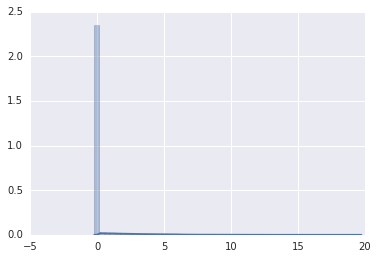

In [252]:
sns.distplot(scipy.stats.zscore(flattened_scores))

In [250]:
scipy.stats.ttest_1samp([1,2,3],2f)

Ttest_1sampResult(statistic=0.0, pvalue=1.0)

# Scratch

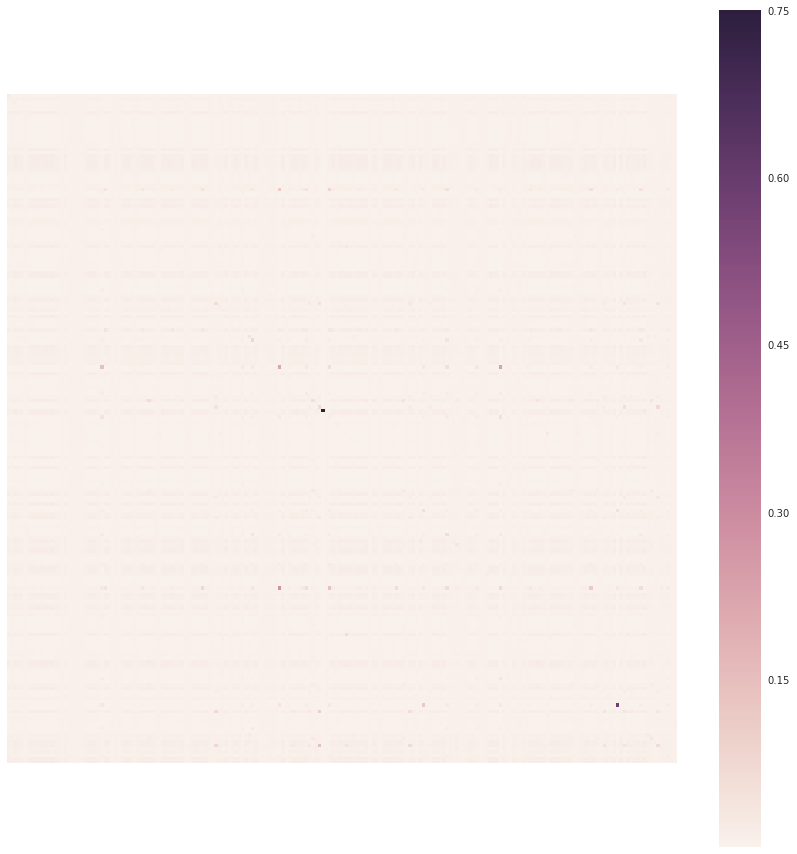

In [505]:
plt.figure(figsize=(15,15))
sns.heatmap(treatment_attention_dict['kla-1h'][0], xticklabels=False, 
            yticklabels=False,
            square = True)

In [515]:
treatment_motifScores_dict['kla-1h'][0].shape

(200, 150)

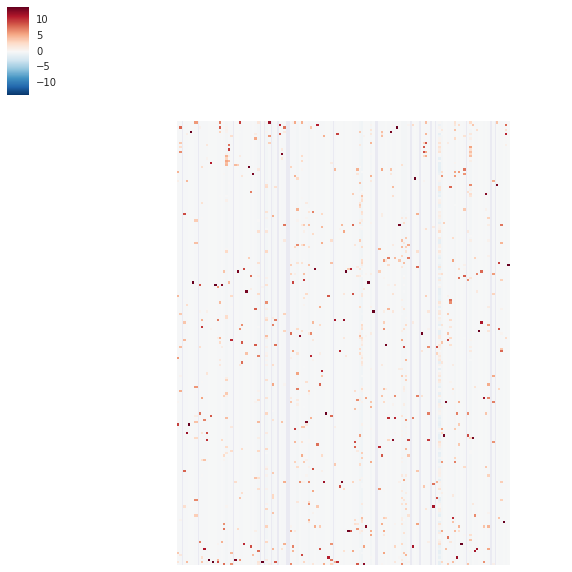

In [519]:
plt.figure(figsize=(15,15))
sns.clustermap(treatment_motifScores_dict['kla-1h'][0],
           xticklabels=False, yticklabels=False,
           square=True,
           z_score=1,
#            cmap='Greens',
           row_cluster = False,
           col_cluster = False)

In [524]:
attention = treatment_attention_dict['kla-1h'][0]

In [528]:
zscores = scipy.stats.zscore(treatment_motifScores_dict['kla-1h'][0], axis=0)

/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [549]:
np.where(attention.max(axis=0) > 0.3)

(array([ 94, 182]),)

In [545]:
treatment_conv_motif_dict['kla-1h']['kla-1h_'+str(np.argmax(zscores[94]))]

'bZIP_1_merged'

In [546]:
treatment_conv_motif_dict['kla-1h']['kla-1h_'+str(np.argmax(zscores[182]))]

'bZIP_1_merged'

In [537]:
zscores[attention.max(axis=0) > 0.3].shape

(2, 150)

In [ ]:
zscores = 

In [522]:
len(set(treatment_conv_motif_dict['kla-1h'].values()))

110

In [ ]:
k
